In [1]:
import os
import json
from dateutil import parser
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# HARD RESET OF STYLE (prevents Jupyter interference)
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("default")
sns.set_theme(style="white")

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

In [2]:
# Path to the ORIGINAL CyberLab dataset (non-segmented)
ROOT_DIR = "../data/CyberLab"


def collect_entries(file_path):
    """
    Read a JSONL log file and return a list of cleaned entries
    (any hostname in ALLOWED_HOSTNAMES) with parsed timestamps
    and non-empty commands, sorted by timestamp.
    """
    entries = []
    with open(file_path, "r") as f:
        for line in f:
            if not line.strip():
                continue
            try:
                entry = json.loads(line)
            except json.JSONDecodeError:
                continue

            # Keep all relevant hostnames (attacker, client, server, laboratory, etc.)
            hostname = entry.get("hostname")
            if hostname not in {"attacker", "client", "server", "laboratory"}:
                continue

            # Parse timestamp
            try:
                ts = parser.isoparse(entry["timestamp_str"])
            except (ValueError, TypeError, KeyError):
                continue

            cmd = entry.get("cmd", "")
            if not cmd:
                continue

            entry["timestamp"] = ts
            entries.append(entry)

    # Ensure chronological order within file
    entries.sort(key=lambda e: e["timestamp"])
    return entries


def build_entry_and_pair_dataframes(root_dir=ROOT_DIR):
    """
    Single pass that builds:
      - df_entries: one row per cleaned command
      - df_pairs:   one row per *consecutive* pair of commands
                    with positive time difference, including
                    file path and neighbouring command context.
    """
    entry_rows = []
    pair_rows = []

    for sample_name in os.listdir(root_dir):
        sample_path = os.path.join(root_dir, sample_name)
        if not os.path.isdir(sample_path):
            continue

        for root, dirs, files in os.walk(sample_path):
            for fname in files:
                if not fname.endswith(".json"):
                    continue

                fpath = os.path.join(root, fname)
                # nice relative path for printing later
                rel_path = os.path.relpath(fpath, root_dir)

                entries = collect_entries(fpath)
                if not entries:
                    continue

                # Per-command rows
                for e in entries:
                    cmd = e.get("cmd", "")
                    entry_rows.append({
                        "sample": sample_name,
                        "sandbox_id": e.get("sandbox_id"),
                        "hostname": e.get("hostname"),
                        "cmd_type": e.get("cmd_type"),
                        "timestamp": e["timestamp"],
                        "cmd": cmd,
                        "cmd_length": len(cmd),
                        "file_relpath": rel_path,
                    })

                # Consecutive pairs
                for i in range(1, len(entries)):
                    prev_e = entries[i - 1]
                    cur_e = entries[i]

                    dt = (cur_e["timestamp"] - prev_e["timestamp"]).total_seconds()
                    # We only skip non-positive dt because you can’t have
                    # a meaningful typing speed otherwise. No upper bound here.
                    if dt <= 0:
                        continue

                    cur_cmd = cur_e.get("cmd", "")
                    cmd_len = len(cur_cmd)
                    if cmd_len == 0:
                        continue

                    pair_rows.append({
                        "sample": sample_name,
                        "sandbox_id": cur_e.get("sandbox_id"),
                        "file_relpath": rel_path,
                        "time_diff": dt,                  # seconds between commands
                        "cmd_length": cmd_len,            # characters (current cmd)
                        "typing_speed": cmd_len / dt,     # chars per second
                        "prev_timestamp": prev_e["timestamp"],
                        "cur_timestamp": cur_e["timestamp"],
                        "prev_cmd": prev_e.get("cmd", ""),
                        "cur_cmd": cur_cmd,
                    })

    df_entries = pd.DataFrame(entry_rows)
    df_pairs = pd.DataFrame(pair_rows)
    return df_entries, df_pairs


def describe_pairs(
    label: str,
    df_subset: pd.DataFrame,
    return_stats: bool = False,
    verbose: bool = True,
):
    """
    Compute descriptive statistics for a given subset of the pairs dataframe.

    Parameters
    ----------
    label : str
        Label used when printing stats (ignored if verbose=False).
    df_subset : pd.DataFrame
        Subset of df_pairs / df_raw / filtered view.
    return_stats : bool, default False
        If True, return a dict with the computed metrics.
    verbose : bool, default True
        If True, print stats to stdout. If False, do not print anything.

    Returns
    -------
    dict or None
        If return_stats=True, returns a dict with metrics.
        Otherwise returns None.
    """
    n = len(df_subset)
    if n == 0:
        if verbose:
            print(f"\n=== {label}: NO ROWS ===")
        return {} if return_stats else None

    # TS (typing speed, chars/s)
    avg_speed    = df_subset["typing_speed"].mean()
    median_speed = df_subset["typing_speed"].median()
    min_speed    = df_subset["typing_speed"].min()
    max_speed    = df_subset["typing_speed"].max()
    std_speed    = df_subset["typing_speed"].std()

    # Time between commands
    avg_time_diff    = df_subset["time_diff"].mean()
    median_time_diff = df_subset["time_diff"].median()
    min_time_diff    = df_subset["time_diff"].min()
    max_time_diff    = df_subset["time_diff"].max()
    std_time_diff    = df_subset["time_diff"].std()

    # Command length
    avg_cmd_len    = df_subset["cmd_length"].mean()
    median_cmd_len = df_subset["cmd_length"].median()
    min_cmd_len    = df_subset["cmd_length"].min()
    max_cmd_len    = df_subset["cmd_length"].max()
    std_cmd_len    = df_subset["cmd_length"].std()

    # Average time per character
    total_cmd_len    = df_subset["cmd_length"].sum()
    total_time_diff  = df_subset["time_diff"].sum()
    avg_time_per_char = (
        total_time_diff / total_cmd_len if total_cmd_len > 0 else np.nan
    )

    if verbose:
        print(f"\n=== {label}: Descriptive Stats ===")
        print(f"Rows: {n:,}")

        print(f"\nTS (chars/s):")
        print(f"  min    = {min_speed:.4f}")
        print(f"  median = {median_speed:.4f}")
        print(f"  mean   = {avg_speed:.4f}")
        print(f"  max    = {max_speed:.4f}")
        print(f"  std    = {std_speed:.4f}")

        print(f"\nTime between commands (s):")
        print(f"  min    = {min_time_diff:.4f}")
        print(f"  median = {median_time_diff:.4f}")
        print(f"  mean   = {avg_time_diff:.4f}")
        print(f"  max    = {max_time_diff:.4f}")
        print(f"  std    = {std_time_diff:.4f}")

        print(f"\nCommand length (characters):")
        print(f"  min    = {min_cmd_len:.0f}")
        print(f"  median = {median_cmd_len:.2f}")
        print(f"  mean   = {avg_cmd_len:.2f}")
        print(f"  max    = {max_cmd_len:.0f}")
        print(f"  std    = {std_cmd_len:.2f}")

        print(f"\nAverage time per character: {avg_time_per_char:.4f} s/char")

    if return_stats:
        return {
            "Rows": n,
            "Average TS": avg_speed,
            "Min TS": min_speed,
            "Max TS": max_speed,
            "Median TS": median_speed,
            "Std TS": std_speed,
            "Average Time Between Commands": avg_time_diff,
            "Min Time Between Commands": min_time_diff,
            "Max Time Between Commands": max_time_diff,
            "Median Time Between Commands": median_time_diff,
            "Std Time Between Commands": std_time_diff,
            "Average Command Length": avg_cmd_len,
            "Min Command Length": min_cmd_len,
            "Max Command Length": max_cmd_len,
            "Median Command Length": median_cmd_len,
            "Std Command Length": std_cmd_len,
            "Average Time Per Character": avg_time_per_char,
        }


# ---------------------------------------------------------------------
# Build dataframes and show RAW stats
# ---------------------------------------------------------------------

df_entries, df_pairs = build_entry_and_pair_dataframes(ROOT_DIR)

print("=== Basic counts ===")
print(f"Total rows (cleaned entries, all hostnames): {len(df_entries):,}")
print(f"Total analysable consecutive pairs:          {len(df_pairs):,}")

if df_pairs.empty:
    raise RuntimeError("No consecutive pairs found - check ROOT_DIR / parsing logic.")

# Keep a raw copy so we can compare later
df_raw = df_pairs.copy()
df = df_raw  # alias for “current working view”

describe_pairs("CORE METRICS - RAW (no thresholds)", df)


=== Basic counts ===
Total rows (cleaned entries, all hostnames): 13,015
Total analysable consecutive pairs:          12,704

=== CORE METRICS - RAW (no thresholds): Descriptive Stats ===
Rows: 12,704

TS (chars/s):
  min    = 0.0000
  median = 0.8935
  mean   = 86.0818
  max    = 55000.0000
  std    = 1101.4029

Time between commands (s):
  min    = 0.0003
  median = 15.2267
  mean   = 457.7146
  max    = 721217.7540
  std    = 11484.8916

Command length (characters):
  min    = 1
  median = 12.00
  mean   = 18.35
  max    = 1049
  std    = 23.87

Average time per character: 24.9425 s/char


## Key assumptions prior to review

- All entries are from humans interactively typing commands
- Copy + paste activity is assumed minimal/negligible
- NO automated/scripted behaviour
- Sessions are self-contained and do not span multiple days (from the paper: median difference between the first and last command was one hour and 13 minutes)
- Session data within each JSON file corresponds to ONE and ONLY ONE user (paper confirms this; each sandbox_id is a unique user session)

## Review of descriptive statistics in the context of the above assumptions

- Typing speed max of 37735 char/s is problematic, inflating mean + stddev. Indicative of automated / script behaviour (unexpected but good to know; violates our assumption the dataset is purely humans interactively 'typing away')
- Max time between commands of 721217 seconds equates to ~8.35 days. Indicative of datetime entries within a session (useractions.json) spanning multiple days.
- Max command length of 1049 is unusual given the median of 13. It might be legitimate, but it is more likely indicative of copy + paste activity or scripted behaviour. Review of associated typing speed required to confirm.

## Initial thoughts + findings

- Median stats for each key metric appear reasonable. Typing (char/s): 0.8463, Time between commands (s): 17.4620, Command length (chars): 13.00
- Mean stats are skewed by extreme outliers, particularly for typing speed and time between commands
- Overall, the dataset appears to contain a significant amount of noise / outliers that violate our initial assumptions. Next, we can establish some plausible 'human-ish' thresholds to filter these out and inspect the cleaned data. Note: this is exploratory and subjective. Hard-coded subjective thresholds are not ideal, nor the intended approach for the final model



## Quick plots to illustrate the unfiltered data distributions + show presence of outliers

- Typing speed distribution plot (count vs char/s)
- Command length distribution plot (count vs character length)
- Hexbin plot (command length vs typing speed)
- 2D histogram (command length vs typing speed with log colour scale)

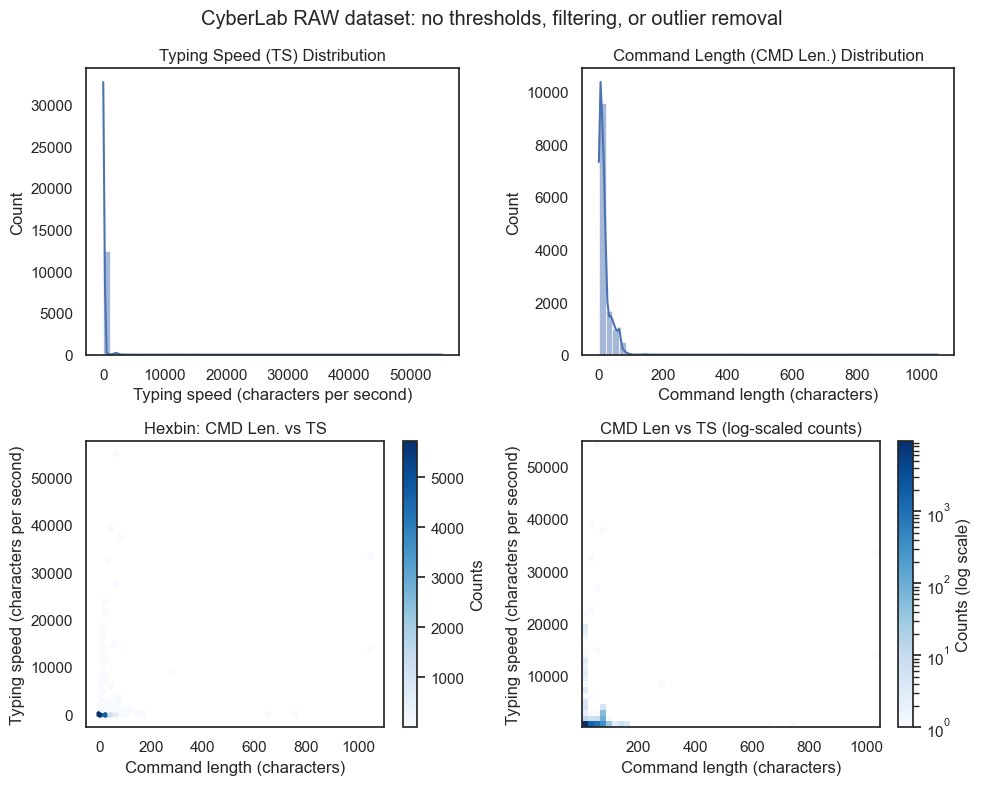

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# ---------------------------------------------------------------------
# Top-left: typing speed distribution
# ---------------------------------------------------------------------
sns.histplot(
    df["typing_speed"],
    bins=50,
    kde=True,
    ax=axes[0, 0],
    color="#4c72b0"
)
axes[0, 0].set_title("Typing Speed (TS) Distribution")
axes[0, 0].set_xlabel("Typing speed (characters per second)")
axes[0, 0].set_ylabel("Count")

# ---------------------------------------------------------------------
# Top-right: command length distribution
# ---------------------------------------------------------------------
sns.histplot(
    df["cmd_length"],
    bins=50,
    kde=True,
    ax=axes[0, 1],
    color="#4c72b0"
)
axes[0, 1].set_title("Command Length (CMD Len.) Distribution")
axes[0, 1].set_xlabel("Command length (characters)")
axes[0, 1].set_ylabel("Count")

# ---------------------------------------------------------------------
# Bottom-left: hexbin (command length vs typing speed)
# ---------------------------------------------------------------------
hb = axes[1, 0].hexbin(
    df["cmd_length"],
    df["typing_speed"],
    gridsize=50,
    mincnt=1,
    cmap="Blues"
)
axes[1, 0].set_title("Hexbin: CMD Len. vs TS")
axes[1, 0].set_xlabel("Command length (characters)")
axes[1, 0].set_ylabel("Typing speed (characters per second)")
cbar_hb = fig.colorbar(hb, ax=axes[1, 0])
cbar_hb.set_label("Counts")

# ---------------------------------------------------------------------
# Bottom-right: 2D histogram with log colour scale
# ---------------------------------------------------------------------
hist = axes[1, 1].hist2d(
    df["cmd_length"],
    df["typing_speed"],
    bins=50,
    cmap="Blues",
    norm=LogNorm()
)
axes[1, 1].set_title("CMD Len vs TS (log-scaled counts)")
axes[1, 1].set_xlabel("Command length (characters)")
axes[1, 1].set_ylabel("Typing speed (characters per second)")
cbar_hist = fig.colorbar(hist[3], ax=axes[1, 1])
cbar_hist.set_label("Counts (log scale)")

fig.suptitle("CyberLab RAW dataset: no thresholds, filtering, or outlier removal")
plt.tight_layout()
plt.show()


### Joint KDE: command length vs typing speed in log-log space

This plot looks at the relationship between command length and typing speed after applying a base-10 log transform to both:

- $x = \log_{10}(\text{command length in characters})$
- $y = \log_{10}(\text{typing speed in characters per second})$

Only pairs with `cmd_length > 0` and `typing_speed > 0` are used.

**Why log10 here**

- Both variables span several orders of magnitude (very short vs very long commands, very slow vs extremely fast “typing”).
- On the original scale, the dense human-ish region dominates and the tails are hard to see.
- Working in log10 space compresses the extremes and spreads out the main mass, which is more useful for spotting structure.

**What the plot shows**

- A main, dense blob around:
  - command length ≈ 10-30 characters → $\log_{10} \approx 1$-1.5
  - typing speed ≈ 0.3-3 chars/s → $\log_{10} \approx -0.5$-0.5
  This is consistent with “normal” interactive use.
- Much sparser density at higher log(typing speed), i.e. orders of magnitude faster than typical human typing. These regions line up with the extreme typing-speed outliers seen earlier and are good candidates for automated / copy-paste behaviour.

**Why keep this plot**

- Confirms that the bulk of the data sits in a compact, human-plausible region once extreme values are viewed on a log scale.
- Makes the separation between “normal” and “suspiciously fast” regimes visually obvious, which is helpful when justifying later threshold choices or more formal modelling in log space.


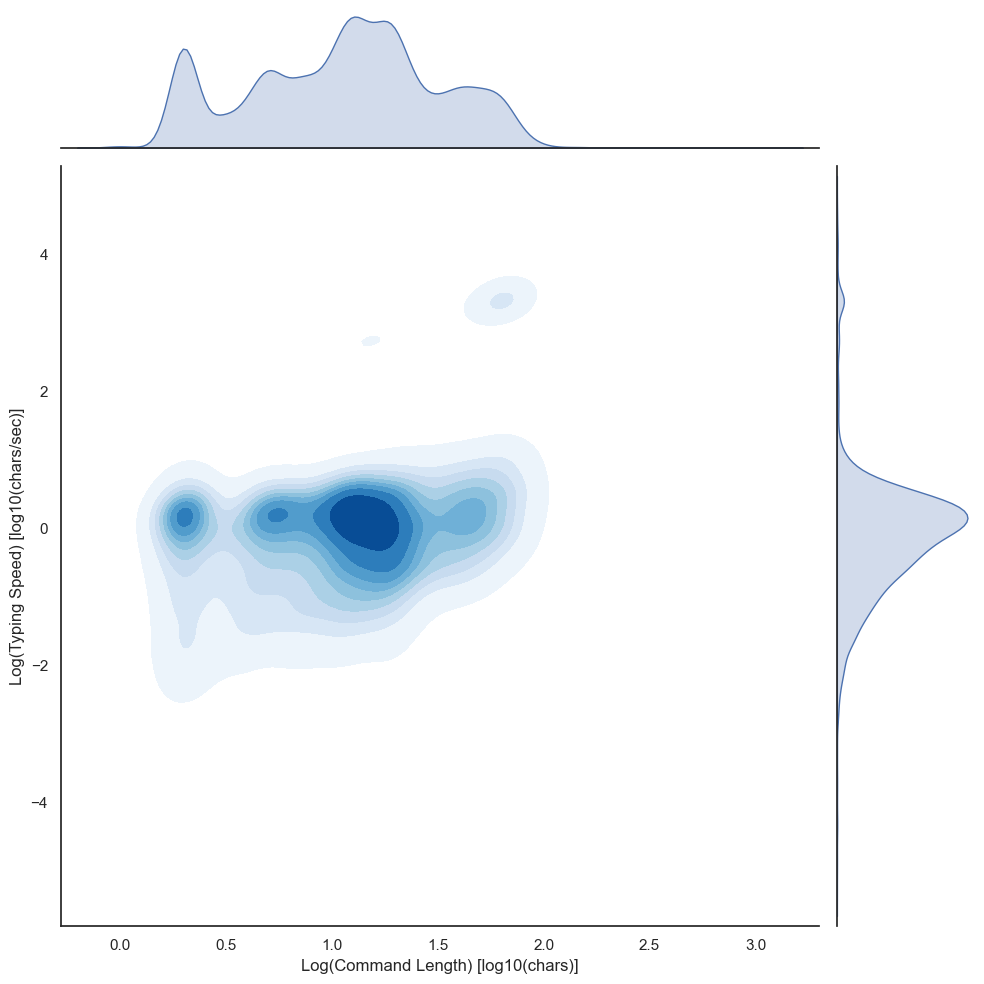

In [4]:
# Joint KDE in log-log space (base 10)
# x = log10(cmd_length), y = log10(typing_speed)

try:
    df_log = df[(df["cmd_length"] > 0) & (df["typing_speed"] > 0)].copy()
    df_log["log_cmd_length"] = np.log10(df_log["cmd_length"])
    df_log["log_typing_speed"] = np.log10(df_log["typing_speed"])

    g_log = sns.jointplot(
        x="log_cmd_length", y="log_typing_speed",
        data=df_log,
        kind="kde", fill=True, cmap="Blues", height=10
    )
    g_log.set_axis_labels(
        "Log(Command Length) [log10(chars)]",
        "Log(Typing Speed) [log10(chars/sec)]"
    )
    plt.tight_layout()
    plt.show()
    plt.close()
except Exception as e:
    print(f"Error: {e}")

## Human-ish filtering heuristic

Analysis up to point has revealed the key metrics of interest, but also highlighted significant outliers that violate our assumptions.
Next, we define a **subjective** human-ish boundary on the 3 key metrics to filter out extreme outliers likely corresponding to pure copy + paste or scripted behaviour.
This is purely EXPLORATORY and SUBJECTIVE. The aim of this human-ish boundary is to establish, once extreme outliers are removed, whether the cleaned data represents what we consider 'plausible' human typing behaviour.
Treat this approach as a: "What does the data look like if we only consider plausible human typing behaviour?".

On typing speed (characters per second), we estbalish a minimum and maximum threshold:
- `MINIMUM_TYPING_SPEED` is set to 0.10 char/s so extremely slow typing is excluded, which may be indicative of long pauses or distractions during the session
- `MAXIMUM_TYPING_SPEED` is set to 10.00 char/s, above which is considered 'superhuman' typing speed likely indicative of copy + paste or scripted behaviour

On time between commands (seconds), we set:
- `MINIMUM_TIME_DIFF` of 1.0 second to exclude ultra-fast consecutive commands likely indicative of scripted behaviour
- `MAXIMUM_TIME_DIFF` of 300.0 seconds (5 minutes) to exclude very long pauses between commands that may indicate breaks in the session or non-interactive behaviour

On command length (characters), we set:
- `MINIMUM_CMD_LENGTH` of 2 characters to exclude single-character commands which are rare and less informative
- `MAXIMUM_CMD_LENGTH` of 100 characters to exclude very long commands likely indicative of copy + paste or scripted behaviour

In [5]:
# Define a “human-ish” box (purely exploratory / subjective)

# Typing speed (characters per second)
MIN_TYPING_SPEED = 0.10
MAX_TYPING_SPEED = 10.00

# Time between commands (seconds)
MIN_TIME_DIFF = 1.0
MAX_TIME_DIFF = 300.0

# Command length (characters)
MIN_CMD_LENGTH = 2
MAX_CMD_LENGTH = 100

mask_human = (
    (df_raw["typing_speed"] >= MIN_TYPING_SPEED) &
    (df_raw["typing_speed"] <= MAX_TYPING_SPEED) &
    (df_raw["time_diff"]    >= MIN_TIME_DIFF) &
    (df_raw["time_diff"]    <= MAX_TIME_DIFF) &
    (df_raw["cmd_length"]   >= MIN_CMD_LENGTH) &
    (df_raw["cmd_length"]   <= MAX_CMD_LENGTH)
)

df_human = df_raw[mask_human].copy()

print("\n=== FILTER: Human-ish heuristic box ===")
print(f"Total RAW pairs:              {len(df_raw):,}")
print(f"Pairs inside human-ish box:   {len(df_human):,} "
      f"({len(df_human)/len(df_raw)*100:.2f}% of all pairs)")

# Quick sanity check on max typing speed before/after
print(f"\nMax typing speed RAW:         {df_raw['typing_speed'].max():.2f} cps")
print(f"Max typing speed human-ish:   {df_human['typing_speed'].max():.2f} cps")

describe_pairs("Human-ish region (heuristic thresholds)", df_human)



=== FILTER: Human-ish heuristic box ===
Total RAW pairs:              12,704
Pairs inside human-ish box:   10,189 (80.20% of all pairs)

Max typing speed RAW:         55000.00 cps
Max typing speed human-ish:   10.00 cps

=== Human-ish region (heuristic thresholds): Descriptive Stats ===
Rows: 10,189

TS (chars/s):
  min    = 0.1000
  median = 1.0015
  mean   = 1.5016
  max    = 10.0000
  std    = 1.5479

Time between commands (s):
  min    = 1.0000
  median = 12.9130
  mean   = 28.8573
  max    = 296.0170
  std    = 39.9648

Command length (characters):
  min    = 2
  median = 13.00
  mean   = 18.65
  max    = 100
  std    = 17.07

Average time per character: 1.5477 s/char


## Human-ish distributions + plots

Same plots as before, but now on the human-ish subset only  
It should now more closely resemble plausible human typing behaviour

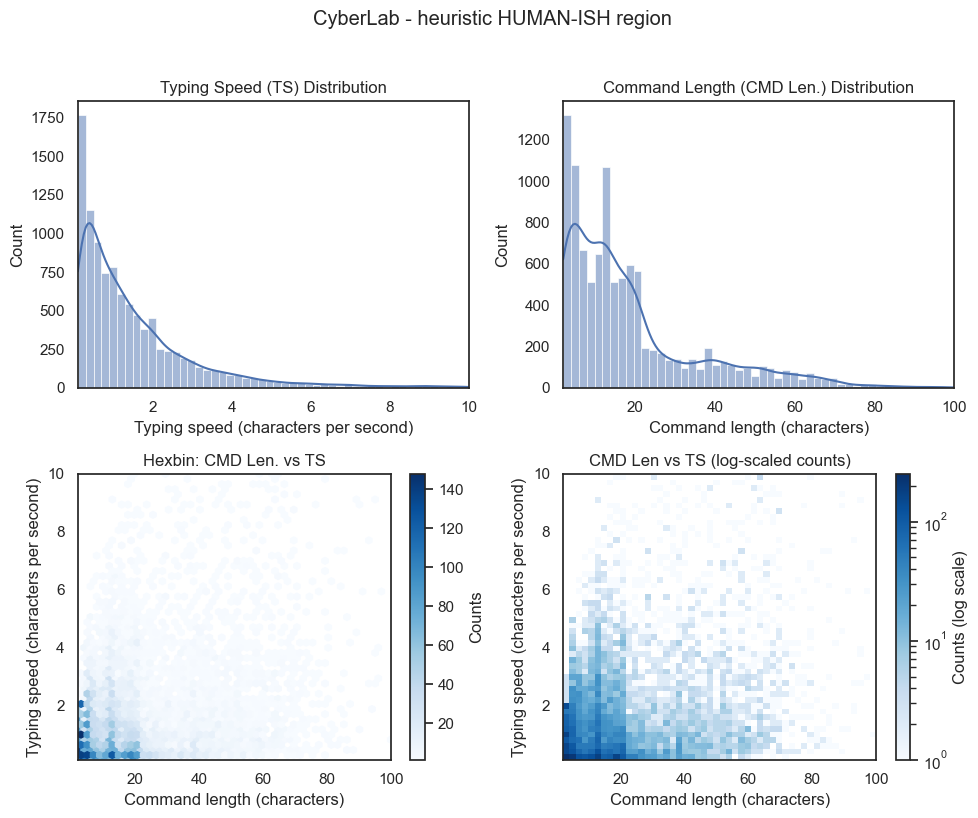

In [6]:
# FIGURE: 2x2 grid on HUMAN-ISH subset

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Top-left: typing speed distribution (human-ish)
sns.histplot(
    df_human["typing_speed"],
    bins=50,
    kde=True,
    ax=axes[0, 0],
    color="#4c72b0"
)
axes[0, 0].set_title("Typing Speed (TS) Distribution")
axes[0, 0].set_xlabel("Typing speed (characters per second)")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xlim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)

# Top-right: command length distribution (human-ish)
sns.histplot(
    df_human["cmd_length"],
    bins=50,
    kde=True,
    ax=axes[0, 1],
    color="#4c72b0"
)
axes[0, 1].set_title("Command Length (CMD Len.) Distribution")
axes[0, 1].set_xlabel("Command length (characters)")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xlim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)

# Bottom-left: hexbin (cmd_length vs typing_speed)
hb = axes[1, 0].hexbin(
    df_human["cmd_length"],
    df_human["typing_speed"],
    gridsize=50,
    mincnt=1,
    cmap="Blues"
)
axes[1, 0].set_title("Hexbin: CMD Len. vs TS")
axes[1, 0].set_xlabel("Command length (characters)")
axes[1, 0].set_ylabel("Typing speed (characters per second)")
axes[1, 0].set_xlim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)
axes[1, 0].set_ylim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)
cbar_hb = fig.colorbar(hb, ax=axes[1, 0])
cbar_hb.set_label("Counts")

# Bottom-right: 2D histogram with log colour scale
hist = axes[1, 1].hist2d(
    df_human["cmd_length"],
    df_human["typing_speed"],
    bins=50,
    cmap="Blues",
    norm=LogNorm()
)
axes[1, 1].set_title("CMD Len vs TS (log-scaled counts)")
axes[1, 1].set_xlabel("Command length (characters)")
axes[1, 1].set_ylabel("Typing speed (characters per second)")
axes[1, 1].set_xlim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)
axes[1, 1].set_ylim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)
cbar_hist = fig.colorbar(hist[3], ax=axes[1, 1])
cbar_hist.set_label("Counts (log scale)")

fig.suptitle("CyberLab - heuristic HUMAN-ISH region", y=1.02)
plt.tight_layout()
plt.show()


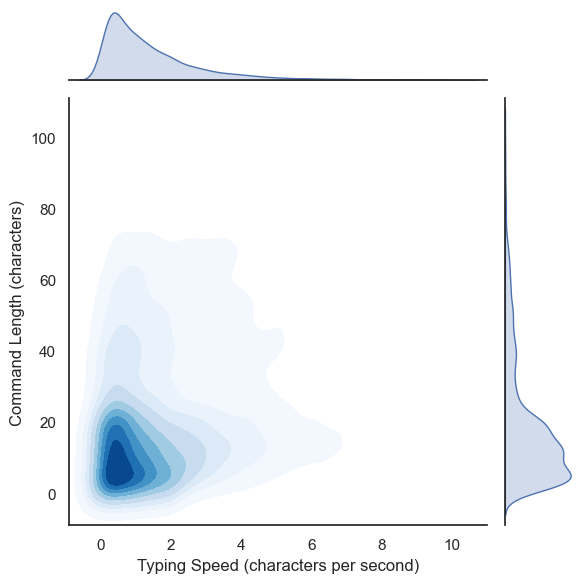

In [7]:
# Joint KDE: Typing speed vs command length - HUMAN-ISH subset

try:
    g = sns.jointplot(
        x="typing_speed",
        y="cmd_length",
        data=df_human,
        kind="kde",
        fill=True,
        cmap="Blues",
        height=6
    )
    # Uncomment if you want the explicit human-ish bounds
    # Prefer no axes limits so the KDE can show density tapering off naturally
    # KDE is an estimation, hence you see density below 0
    # g.ax_joint.set_xlim(MIN_TYPING_SPEED, MAX_TYPING_SPEED)
    # g.ax_joint.set_ylim(MIN_CMD_LENGTH, MAX_CMD_LENGTH)

    g.set_axis_labels(
        "Typing Speed (characters per second)",
        "Command Length (characters)"
    )

    plt.tight_layout()
    plt.show()
    plt.close()
except Exception as e:
    print(f"Error: {e}")


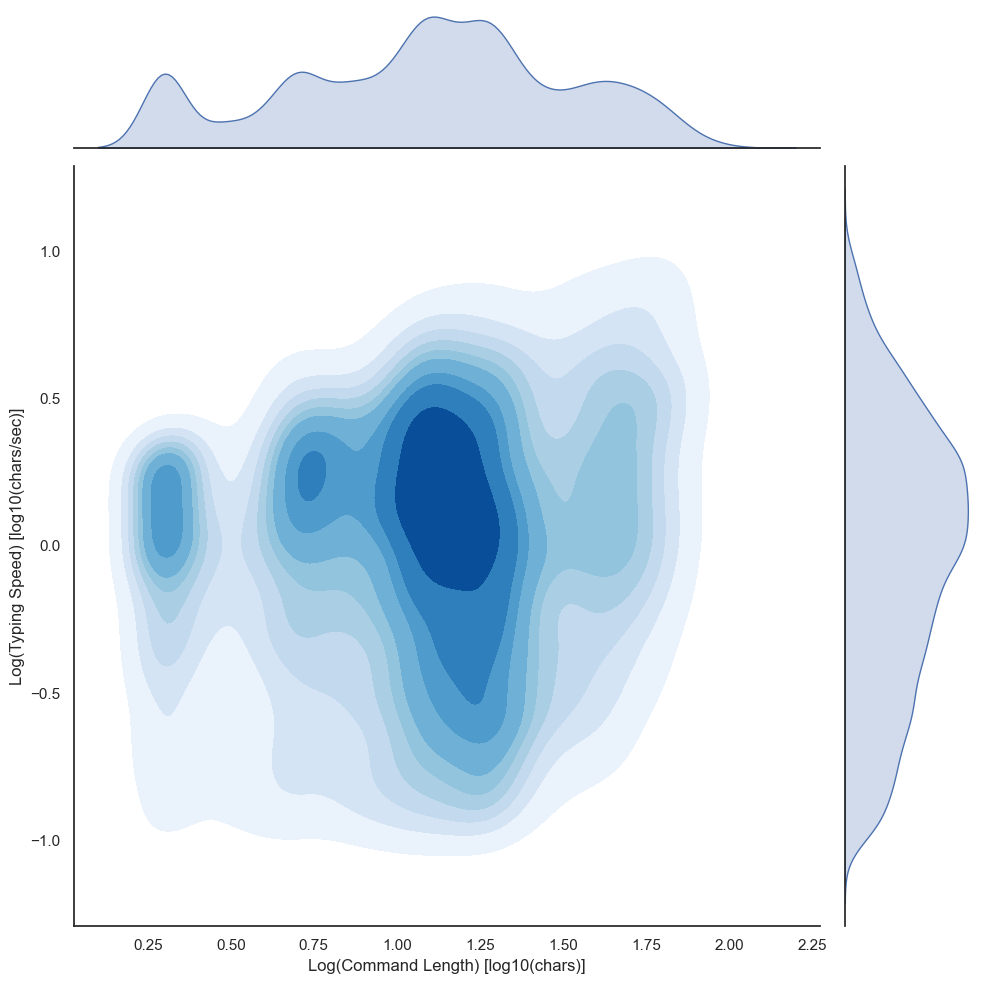

In [8]:
# Joint KDE in log10-log10 space - HUMAN-ISH subset

try:
    df_human_log = df_human[(df_human["cmd_length"] > 0) & (df_human["typing_speed"] > 0)].copy()
    df_human_log["log_cmd_length"] = np.log10(df_human_log["cmd_length"])
    df_human_log["log_typing_speed"] = np.log10(df_human_log["typing_speed"])

    g_log_human = sns.jointplot(
        x="log_cmd_length", y="log_typing_speed",
        data=df_human_log,
        kind="kde", fill=True, cmap="Blues", height=10
    )
    g_log_human.set_axis_labels(
        "Log(Command Length) [log10(chars)]",
        "Log(Typing Speed) [log10(chars/sec)]"
    )
    plt.tight_layout()
    plt.show()
    plt.close()
except Exception as e:
    print(f"Error: {e}")


## Per-sample statistics: RAW

Quick overview of the key metrics within each sample.  
As each sample in `CyberLab/` corresponds to a different sandbox environment featuring a different challenge, it is expected that typing behaviour may vary between samples.  
Aim of this analysis then is to uncover any significant differences within the samples.  
Helps identify any samples that may feature outliers or unusual typing behaviour.

In [9]:
# Per-sample statistics (RAW, no thresholds)

sample_stats_rows_raw = []

for sample_name, df_sample in df_raw.groupby("sample"):
    stats = describe_pairs(f"SAMPLE (RAW): {sample_name}", df_sample, return_stats=True)
    stats["Sample"] = sample_name
    sample_stats_rows_raw.append(stats)

df_sample_stats_raw = (
    pd.DataFrame(sample_stats_rows_raw)
    .set_index("Sample")
    .sort_index()
)

print("\n=== Per-sample stats (RAW, no thresholds) ===")
display(df_sample_stats_raw.round(4))

if not os.path.exists("output"):
    os.makedirs("output")
raw_stats_path = "output/per_sample_stats_raw.csv"
df_sample_stats_raw.to_csv(raw_stats_path, index=True)
print(f"Saved to {raw_stats_path}")



=== SAMPLE (RAW): House of cards: Descriptive Stats ===
Rows: 1,239

TS (chars/s):
  min    = 0.0000
  median = 0.7290
  mean   = 16.4653
  max    = 3721.1886
  std    = 182.9691

Time between commands (s):
  min    = 0.0153
  median = 18.5499
  mean   = 2755.1760
  max    = 431675.0182
  std    = 28419.4549

Command length (characters):
  min    = 1
  median = 13.00
  mean   = 16.72
  max    = 163
  std    = 13.72

Average time per character: 164.8237 s/char

=== SAMPLE (RAW): Junior hacker: Descriptive Stats ===
Rows: 1,662

TS (chars/s):
  min    = 0.0000
  median = 1.0000
  mean   = 1.8981
  max    = 64.0000
  std    = 3.3399

Time between commands (s):
  min    = 1.0000
  median = 13.5000
  mean   = 602.0596
  max    = 270236.0000
  std    = 9383.0127

Command length (characters):
  min    = 1
  median = 13.00
  mean   = 20.50
  max    = 96
  std    = 20.37

Average time per character: 29.3696 s/char

=== SAMPLE (RAW): Junior hacker adaptive: Descriptive Stats ===
Rows: 4,093

TS

,Rows,Average TS,Min TS,Max TS,Median TS,Std TS,Average Time Between Commands,Min Time Between Commands,Max Time Between Commands,Median Time Between Commands,Std Time Between Commands,Average Command Length,Min Command Length,Max Command Length,Median Command Length,Std Command Length,Average Time Per Character
Sample,,,,,,,,,,,,,,,,,
House of cards,1239,16.4653,0.0000,3721.1886,0.7290,182.9691,2755.1760,0.0153,431675.0182,18.5499,28419.4549,16.7159,1,163,13.0,13.7197,164.8237
Junior hacker,1662,1.8981,0.0000,64.0000,1.0000,3.3399,602.0596,1.0000,270236.0000,13.5000,9383.0127,20.4994,1,96,13.0,20.3743,29.3696
Junior hacker adaptive,4093,114.4342,0.0013,55000.0000,0.9756,1600.2440,49.6710,0.0010,3044.4900,11.9430,127.6679,16.0520,1,97,10.0,17.2930,3.0944
Kobylka 3302,3491,163.1814,0.0002,37735.8491,1.0000,1161.6708,81.2745,0.0003,37916.2137,15.2324,694.4400,20.8273,1,1049,14.0,31.6324,3.9023
SQL injection,170,0.9015,0.0011,11.9467,0.3786,1.4545,239.3086,1.7690,4017.9330,62.5280,556.8261,28.4706,2,103,24.0,21.9809,8.4055
Secret laboratory,1235,25.0796,0.0000,7000.0000,0.6950,320.1229,655.2993,0.0010,721217.7540,20.4140,20521.5972,17.4648,1,754,13.0,31.4901,37.5212
Webmin exploit practice,814,1.0514,0.0020,19.4276,0.5856,1.5226,78.0225,0.5896,2477.6696,22.8108,180.3917,16.6204,1,108,12.0,16.3230,4.6944


Saved to output/per_sample_stats_raw.csv


## RAW per-sample stats observations

- Inflated average typing speed across House of cards, Junior hacker adaptive, Kobylka 3302, and Secret laboratory. Max TS is in the thousands of char/s which inflates the mean and stddev.
- Average time between commands is inflated for House of cards, Junior hacker, SQL injection, and Secret laboratory. Max time across population is in Secret laboratory at 721217 seconds (~8.35 days).
- Command lengths look reasonable, but the max of 1049 in Kobylka 3302 should still be considered an outlier.
- Median stats across all samples on all metrics remain reasonable, indicating that the bulk of the data is likely human-interactive

## Per-sample statistics: HUMAN-ISH subset

The same per-sample statistics as before, but now on the HUMAN-ISH subset only using the subjective thresholds defined earlier.

- Average TS, as expected, is now much more reasonable given the max TS is capped at 10 char/s
- Average time between commands is also more stable, however ALL samples feature a maximum nearing the cap (300s or 5 minutes). It is therefore plausible, given this dataset, that some users spend extended periods thinking before entering their next command.
- Max command lengths across each sample also hit near the cap of 100 characters. We know this is consistent across samples, excluding Kobylka 3302 and Secret laboratory which have a max of 1049 and 754, respectively in the RAW data (no filtering).

In [10]:
# Per-sample statistics (HUMAN-ish subset)

# Confirm we're using human-ish DF
df_human = df_raw[mask_human].copy()

sample_stats_rows_human = []

for sample_name, df_sample in df_human.groupby("sample"):
    stats = describe_pairs(f"SAMPLE (HUMAN-ish): {sample_name}", df_sample, return_stats=True)
    stats["Sample"] = sample_name
    sample_stats_rows_human.append(stats)

df_sample_stats_human = (
    pd.DataFrame(sample_stats_rows_human)
    .set_index("Sample")
    .sort_index()
)

print("\n=== Per-sample stats (HUMAN-ish subset) ===")
display(df_sample_stats_human.round(4))

human_stats_path = "output/per_sample_stats_human_ish.csv"
df_sample_stats_human.to_csv(human_stats_path, index=True)
print(f"Saved to {human_stats_path}")


=== SAMPLE (HUMAN-ish): House of cards: Descriptive Stats ===
Rows: 1,012

TS (chars/s):
  min    = 0.1005
  median = 0.9337
  mean   = 1.4294
  max    = 9.4550
  std    = 1.4851

Time between commands (s):
  min    = 1.0890
  median = 14.1239
  mean   = 30.2010
  max    = 284.6167
  std    = 40.9597

Command length (characters):
  min    = 2
  median = 13.00
  mean   = 16.72
  max    = 95
  std    = 12.53

Average time per character: 1.8068 s/char

=== SAMPLE (HUMAN-ish): Junior hacker: Descriptive Stats ===
Rows: 1,403

TS (chars/s):
  min    = 0.1000
  median = 1.1964
  mean   = 1.7568
  max    = 10.0000
  std    = 1.7661

Time between commands (s):
  min    = 1.0000
  median = 11.0000
  mean   = 26.4341
  max    = 294.0000
  std    = 39.5530

Command length (characters):
  min    = 2
  median = 14.00
  mean   = 21.33
  max    = 96
  std    = 20.75

Average time per character: 1.2391 s/char

=== SAMPLE (HUMAN-ish): Junior hacker adaptive: Descriptive Stats ===
Rows: 3,398

TS (char

,Rows,Average TS,Min TS,Max TS,Median TS,Std TS,Average Time Between Commands,Min Time Between Commands,Max Time Between Commands,Median Time Between Commands,Std Time Between Commands,Average Command Length,Min Command Length,Max Command Length,Median Command Length,Std Command Length,Average Time Per Character
Sample,,,,,,,,,,,,,,,,,
House of cards,1012,1.4294,0.1005,9.4550,0.9337,1.4851,30.2010,1.0890,284.6167,14.1239,40.9597,16.7154,2,95,13.0,12.5325,1.8068
Junior hacker,1403,1.7568,0.1000,10.0000,1.1964,1.7661,26.4341,1.0000,294.0000,11.0000,39.5530,21.3336,2,96,14.0,20.7483,1.2391
Junior hacker adaptive,3398,1.4464,0.1001,9.9734,1.0612,1.3953,26.7156,1.0000,296.0170,10.0890,39.0194,17.5756,2,97,11.0,17.8139,1.5200
Kobylka 3302,2631,1.5930,0.1002,10.0000,1.0326,1.6447,28.3329,1.0000,273.8979,14.6833,36.8512,19.1174,2,96,15.0,15.7413,1.4820
SQL injection,123,1.1171,0.1020,7.6428,0.6663,1.2680,60.8302,1.7690,278.8700,40.1970,63.3434,31.3089,2,100,34.0,21.2515,1.9429
Secret laboratory,964,1.4148,0.1006,9.9891,0.8551,1.6234,32.4582,1.0000,245.9160,15.7745,42.0867,17.8506,2,87,15.0,14.4563,1.8183
Webmin exploit practice,658,1.1876,0.1005,9.7712,0.7712,1.3085,33.8615,1.0337,267.5326,15.1267,43.8403,18.3222,2,94,13.0,16.6306,1.8481


Saved to output/per_sample_stats_human_ish.csv


## Moving forward

- The HUMAN-ISH heuristic thresholds were purely EXPLORATORY and are NOT the intended approach. They work as a sanity check primarily, and as a secondary fallback in the event an alternative data-driven filtering approach is not feasible.
- The reason for this is because it is hard to defend subjective thresholds. It is logical, and occasionally defensible, to impose hard physiological constraints (e.g. "no human can consistently exceed $5$-$7$ cps" or "no human pauses $>300$ seconds mid-session"), but these must be justified, measurable, and non-arbitrary.

## Tukey-based outlier removal

Rather than relying on heuristic thresholds, we adopt Tukey’s method to identify unusually large time gaps between sequential commands. Tukey’s approach is appealing here because:

- It is **non-parametric** - it does not assume normality or any specific distribution for inter-command delays.
- It is **robust to skewness**, which is essential because time gaps are typically heavy-tailed.
- It can be applied **per sample x sandbox session**, allowing the threshold to adapt to each user/session rather than enforcing a global rule.

### Core idea behind Tukey's fences

Given a 1D series of positive time differences: $\{t_1, t_2, \dots, t_n\}$, Tukey’s fences identify points lying beyond:

- the first quartile $Q_1$ (25th percentile)
- the third quartile $Q_3$ (75th percentile)
- the interquartile range $IQR = Q_3 - Q_1$

The **upper Tukey fence** is defined as:

$\text{UpperFence} = Q_3 + 1.5 \times IQR.$

Points with

$t_i > \text{UpperFence}$

are flagged as extreme outliers.

### Why only the upper fence?

For this application, we are only interested in removing **very large delays**, since:

- Long gaps likely indicate session breaks, lost focus, or non-interactive automation, rather than meaningful human typing behaviour.
- Very small gaps (including near-zero values) are **not** to be removed, because they correspond to realistic copy-paste, rapid command execution, or scripted bursts that humans can legitimately produce

Hence, we ignore the lower fence and use only:

$t_i > Q_3 + 1.5\,IQR.$

### Importance of retaining very small gaps

- The entire purpose of this analysis is to build a model of human typing behaviour. Instinctively, the starting point was to try to capture only 'pure' human typing, which is the interactive hands-on-keyboard behaviour.
- In reality, given the dataset is based on interactions with a shell focused on completing technical cyber-security challenges, it is only fair (and normal) to expect copy + paste activity and the use of scripts to automate repetitive tasks.
- Hence, retaining very small gaps is crucial to accurately reflect real-world human behaviour in this context.
- This translates nicely over to typing analysis in honeypots, where the attacker is unknown, but it is expected to be a mix of automated (scripts, bots) and interactive (human) behaviour, with the latter likely including copy + paste, if not additional scripting.

### Per-session computation

To avoid mixing behaviours across sessions, the fence is computed **independently** for each (`sample`, `sandbox_id`) group. Each group may have its own tempo, burstiness, or interaction style, so the adaptive threshold prevents over-filtering.

### Practical handling of edge cases

If a given session has:

- fewer than 4 valid time gaps, or
- zero $IQR$ (all gaps identical or almost identical),

then Tukey’s $IQR$ collapses and no meaningful fence exists. In these cases, we set:

$\text{UpperFence} = +\infty,$

meaning **no outliers are removed** - a principled, safe fallback.

### Summary

This Tukey-based step provides a **data-driven**, **distribution-aware**, and **session-specific** way to filter extreme delays without imposing subjective limits.


In [11]:
# Tukey-based filtering on time_diff (per sample+session).
# We only remove pairs with large gaps in time.
# Small gaps (including near-zero) are kept: we want copy+paste & scripts.
# Tukey upper fence only (to remove large time gaps).

df_entries, df_pairs = build_entry_and_pair_dataframes(ROOT_DIR)

def tukey_upper_fence(series: pd.Series) -> float:
    """
    Compute Tukey's upper fence for a 1D series of time_diffs (seconds).
    Only uses positive, finite values. If there are too few points or
    zero IQR, returns +inf (i.e., no upper fence -> no outliers removed).
    """
    s = series[(series > 0) & np.isfinite(series)]
    if len(s) < 4:
        return np.inf

    q1 = np.percentile(s, 25)
    q3 = np.percentile(s, 75)
    iqr = q3 - q1
    if iqr <= 0:
        return np.inf

    # Upper fence only (IMPORTANT)
    return q3 + 1.5 * iqr


# Again, work on copies so df_raw remains unchanged
df_tukey = df_raw.copy()

# Compute per (sample, sandbox_id) upper fence on time_diff
df_tukey["upper_fence"] = (
    df_tukey
    .groupby(["sample", "sandbox_id"])["time_diff"]
    .transform(tukey_upper_fence)
)

# Mark Tukey outliers: only use the *upper* fence
df_tukey["is_tukey_outlier"] = df_tukey["time_diff"] > df_tukey["upper_fence"]

n_before = len(df_raw)
n_outliers = int(df_tukey["is_tukey_outlier"].sum())

# Keep only non-outlier pairs
df_human_tukey = df_tukey[~df_tukey["is_tukey_outlier"]].copy()
n_after = len(df_human_tukey)

print("=== Tukey-based filtering on time_diff (upper fence only) ===")
print(f"Pairs before filtering : {n_before:,}")
print(f"Pairs marked as outlier: {n_outliers:,}")
print(f"Pairs after filtering  : {n_after:,}")

describe_pairs("CORE METRICS - Tukey (upper fence only)", df_human_tukey)


=== Tukey-based filtering on time_diff (upper fence only) ===
Pairs before filtering : 12,704
Pairs marked as outlier: 1,477
Pairs after filtering  : 11,227

=== CORE METRICS - Tukey (upper fence only): Descriptive Stats ===
Rows: 11,227

TS (chars/s):
  min    = 0.0011
  median = 1.0768
  mean   = 97.3906
  max    = 55000.0000
  std    = 1171.1506

Time between commands (s):
  min    = 0.0003
  median = 11.6822
  mean   = 29.1372
  max    = 3624.9240
  std    = 63.5224

Command length (characters):
  min    = 1
  median = 12.00
  mean   = 18.21
  max    = 1049
  std    = 24.42

Average time per character: 1.6000 s/char


## Quick review after Tukey filtering

- Mean typing speed is largely unchanged from RAW, but is a bit lower as expected. It still features the max of 55000 char/s, also expected and what we want to retain.
- Mean time between commands is now much more reasonable at 29.13 seconds, in contrast with 457 seconds in RAW.
- Command length is very similar, with a slightly lower mean (18.21) compared to RAW (18.35). Max is still 1049. Std now higher at 24.42 compared to 23.87 in RAW.

### Time_diff focus

- Focus here is on time_diff. Whilst the mean has dropped significantly, the max is still considerably high at 3624 seconds (~1 hour). This indicates that a session-specific Tukey upper fence has allowed retention of long pauses if that underlying session's distribution supports it.
- Therefore, we can do a quick inspection to review these edge cases, and understand what the session's structure is (see below)

In [12]:
# Inspect top N largest remaining time gaps (after Tukey upper-fence)

n = 5

df_with_big_gaps = df_human_tukey.sort_values("time_diff", ascending=False).head(n)

print(f"=== Top {n} largest time gaps AFTER Tukey upper-fence filtering ===")
for rank, row in enumerate(df_with_big_gaps.itertuples(index=False), start=1):
    print(f"\n--- #{rank} ---")
    print(f"Sample       : {row.sample}")
    print(f"Sandbox ID   : {row.sandbox_id}")
    print(f"File         : {row.file_relpath}")
    print(f"time_diff    : {row.time_diff:.3f} seconds (~{row.time_diff/3600:.2f} hours)")
    print(f"prev_ts      : {row.prev_timestamp}")
    print(f"cur_ts       : {row.cur_timestamp}")
    print("prev_cmd:")
    print(f"  {row.prev_cmd}")
    print("cur_cmd:")
    print(f"  {row.cur_cmd}")


=== Top 5 largest time gaps AFTER Tukey upper-fence filtering ===

--- #1 ---
Sample       : SQL injection
Sandbox ID   : 131
File         : SQL injection/sandbox-131-useractions.json
time_diff    : 3624.924 seconds (~1.01 hours)
prev_ts      : 2021-01-14 10:15:58.973000+00:00
cur_ts       : 2021-01-14 11:16:23.897000+00:00
prev_cmd:
  ssh webadmin@server
cur_cmd:
  exit

--- #2 ---
Sample       : SQL injection
Sandbox ID   : 131
File         : SQL injection/sandbox-131-useractions.json
time_diff    : 2714.207 seconds (~0.75 hours)
prev_ts      : 2021-01-14 09:30:44.766000+00:00
cur_ts       : 2021-01-14 10:15:58.973000+00:00
prev_cmd:
  nmap -sV --script=http-sql-injection server
cur_cmd:
  ssh webadmin@server

--- #3 ---
Sample       : SQL injection
Sandbox ID   : 122
File         : SQL injection/sandbox-122-useractions.json
time_diff    : 1323.083 seconds (~0.37 hours)
prev_ts      : 2021-01-14 09:21:33.827000+00:00
cur_ts       : 2021-01-14 09:43:36.910000+00:00
prev_cmd:
  ls
cur_

## Top n largest time gaps observations

- As expected, the largest remaining time gaps do not appear to be plausible gaps in typing behaviour. Instead, they correspond to extended breaks in the sessions.
- Interestingly, in the top 5, they correspond to the same sample (SQL injection) and only 2 unique sandbox IDs (122 and 131).

## Toward a global Tukey upper-fence on `time_diff` + per-session AND per-sample stats

The next step is to compute a **single, global** Tukey upper fence on `time_diff` using the entire population of valid time gaps:

- We first recompute Tukey’s $Q_1$, $Q_3$, and $IQR$ on `df_raw["time_diff"]` (restricted to $t_i > 0$ and finite values).
- This yields a population-level upper fence $\text{UpperFence}_{\text{global}} = Q_3 + 1.5 \times IQR$, which defines what counts as an 'unreasonably long' gap **globally**, rather than within each individual session.
- We then apply this global fence back to `df_raw` to obtain `df_pop_tukey_clean`, keeping only pairs with $0 < t_i \le \text{UpperFence}_{\text{global}}$.

### Why a global fence is justified here

The earlier per-session Tukey step showed that:

- Some sessions have very wide, heavy-tailed `time_diff` distributions, allowing **hour-scale gaps** to survive the per-session fence.
- Inspection of the top $n$ gaps confirms that these are **not** subtle variations in human typing latency, but rather **extended breaks** in the interaction (e.g. leaving the environment open and returning much later).

Given this, a global fence is useful because:

1. **It enforces a common notion of “too long to be a single interactive gap” across all sessions.**
   A pause above the global fence is treated as a structural break, regardless of which sample or sandbox produced it.

2. **It prevents pathological sessions from normalising their own extremes.**
   Sessions that contain multiple long idle periods inflate their per-session $IQR$ and hence their per-session upper fence. The global fence counteracts this by anchoring the definition of “too long” to the overall population.

3. **It focuses the analysis on contiguous, engaged interaction.**
   The cleaned dataset `df_pop_tukey_clean` is much better aligned with the goal of measuring **within-session typing behaviour**, not cross-day or cross-task gaps.

In [14]:
# Global Tukey upper-fence on time_diff + per-session AND per-sample stats

# Compute global Tukey upper fence on time_diff (population-level)
time_diffs = df_raw["time_diff"]
s = time_diffs[(time_diffs > 0) & np.isfinite(time_diffs)]

q1 = np.percentile(s, 25)
q3 = np.percentile(s, 75)
iqr = q3 - q1
upper_fence_global = q3 + 1.5 * iqr

print("=== Global Tukey on time_diff (upper fence only) ===")
print(f"Q1  = {q1:.3f} s")
print(f"Q3  = {q3:.3f} s")
print(f"IQR = {iqr:.3f} s")
print(f"Upper fence (global) = {upper_fence_global:.3f} s\n")

# Apply global Tukey filter to df_raw
mask_pop_tukey = (
    (df_raw["time_diff"] > 0) &
    (df_raw["time_diff"] <= upper_fence_global)
)

df_pop_tukey_clean = df_raw[mask_pop_tukey].copy()

print("=== Population-level Tukey filtering on time_diff ===")
print(f"Pairs before filtering : {len(df_raw):,}")
print(f"Pairs marked as outlier: {(~mask_pop_tukey).sum():,}")
print(f"Pairs after filtering  : {len(df_pop_tukey_clean):,}")

# Global, population-level summary (printed)
describe_pairs(
    label="CORE METRICS - POPULATION Tukey (upper fence only)",
    df_subset=df_pop_tukey_clean,
    return_stats=False,
    verbose=True,   # we DO want this printed
)

# Per-session stats (grouped by sample + sandbox_id) - NO per-session prints

session_stats_rows = []

for (sample_name, sandbox_id), df_session in df_pop_tukey_clean.groupby(
    ["sample", "sandbox_id"]
):
    stats = describe_pairs(
        label="",
        df_subset=df_session,
        return_stats=True,
        verbose=False,
    )
    stats["Sample"] = sample_name
    stats["Sandbox ID"] = sandbox_id
    session_stats_rows.append(stats)

df_session_stats = (
    pd.DataFrame(session_stats_rows)
    .set_index(["Sample", "Sandbox ID"])
    .sort_index()
)

print("\n=== Per-session stats (GLOBAL Tukey on time_diff) ===")
display(df_session_stats.round(4))

if not os.path.exists("output"):
    os.makedirs("output")

session_stats_path = "output/per_session_stats_tukey_global.csv"
df_session_stats.to_csv(session_stats_path)
print(f"Saved per-session stats to: {session_stats_path}")

# Per-sample stats (aggregating over all sessions within each sample)

sample_stats_rows_tukey = []

for sample_name, df_sample in df_pop_tukey_clean.groupby("sample"):
    stats = describe_pairs(
        label=f"SAMPLE (Tukey global): {sample_name}",
        df_subset=df_sample,
        return_stats=True,
        verbose=True,
    )
    stats["Sample"] = sample_name
    sample_stats_rows_tukey.append(stats)

df_sample_stats_tukey = (
    pd.DataFrame(sample_stats_rows_tukey)
    .set_index("Sample")
    .sort_index()
)

print("\n=== Per-sample stats (GLOBAL Tukey on time_diff) ===")
display(df_sample_stats_tukey.round(4))

sample_stats_path = "output/per_sample_stats_tukey_global.csv"
df_sample_stats_tukey.to_csv(sample_stats_path)
print(f"Saved per-sample stats to: {sample_stats_path}")


=== Global Tukey on time_diff (upper fence only) ===
Q1  = 4.729 s
Q3  = 54.816 s
IQR = 50.087 s
Upper fence (global) = 129.946 s

=== Population-level Tukey filtering on time_diff ===
Pairs before filtering : 12,704
Pairs marked as outlier: 1,506
Pairs after filtering  : 11,198

=== CORE METRICS - POPULATION Tukey (upper fence only): Descriptive Stats ===
Rows: 11,198

TS (chars/s):
  min    = 0.0089
  median = 1.0827
  mean   = 97.6478
  max    = 55000.0000
  std    = 1172.6554

Time between commands (s):
  min    = 0.0003
  median = 11.5692
  mean   = 24.4747
  max    = 129.8990
  std    = 29.6244

Command length (characters):
  min    = 1
  median = 12.00
  mean   = 18.26
  max    = 1049
  std    = 24.52

Average time per character: 1.3405 s/char

=== Per-session stats (GLOBAL Tukey on time_diff) ===


Rows  Average TS  Min TS   Max TS  \
Sample                  Sandbox ID                                      
House of cards          101           17      0.7195  0.0242   1.6878   
                        112           48      0.8925  0.0563   3.5919   
                        113           16      1.2471  0.1473   6.2992   
                        115           13      0.4372  0.0268   1.7798   
                        116           25      0.9442  0.0915   2.5999   
...                                  ...         ...     ...      ...   
Webmin exploit practice 329           45      1.5002  0.0447   4.1381   
                        331           45      1.1224  0.0283   3.5490   
                        351          153      1.6544  0.0287  19.4276   
                        358           50      0.7588  0.0346   2.2406   
                        374           27      1.5407  0.0316   6.3901   

                                    Median TS  Std TS  \
Sample                  Sandbox ID                      
House of cards          101            0.5225  0.5507   
                        112            0.4084  0.9765   
                        113            0.6346  1.6547   
                        115            0.3406  0.4568   
                        116            0.6789  0.7022   
...                                       ...     ...   
Webmin exploit practice 329            0.9824  1.2113   
                        331            0.6518  1.0624   
                        351            0.9998  2.2426   
                        358            0.7401  0.4936   
                        374            0.4371  1.8988   

                                    Average Time Between Commands  \
Sample                  Sandbox ID                                  
House of cards          101                               33.7676   
                        112                               39.4631   
                        113                               35.8359   
                        115                               41.6782   
                        116                               30.0098   
...                                                           ...   
Webmin exploit practice 329                               26.7883   
                        331                               30.9914   
                        351                               23.1136   
                        358                               32.8371   
                        374                               45.0022   

                                    Min Time Between Commands  \
Sample                  Sandbox ID                              
House of cards          101                            1.7775   
                        112                            1.9606   
                        113                            1.5781   
                        115                            8.8087   
                        116                            1.2882   
...                                                       ...   
Webmin exploit practice 329                            3.0539   
                        331                            0.9875   
                        351                            0.5896   
                        358                            2.4902   
                        374                            1.5649   

                                    Max Time Between Commands  \
Sample                  Sandbox ID                              
House of cards          101                          123.9548   
                        112                          119.7365   
                        113                          129.0109   
                        115                          112.0514   
                        116                          109.2210   
...                                                       ...   
Webmin exploit practice 329                          129.1103   
               

Saved per-session stats to: output/per_session_stats_tukey_global.csv

=== SAMPLE (Tukey global): House of cards: Descriptive Stats ===
Rows: 1,040

TS (chars/s):
  min    = 0.0242
  median = 0.9611
  mean   = 19.6028
  max    = 3721.1886
  std    = 199.5704

Time between commands (s):
  min    = 0.0153
  median = 13.6193
  mean   = 25.6201
  max    = 129.6965
  std    = 29.3854

Command length (characters):
  min    = 1
  median = 13.00
  mean   = 16.38
  max    = 163
  std    = 13.78

Average time per character: 1.5646 s/char

=== SAMPLE (Tukey global): Junior hacker: Descriptive Stats ===
Rows: 1,476

TS (chars/s):
  min    = 0.0160
  median = 1.2000
  mean   = 2.1260
  max    = 64.0000
  std    = 3.4779

Time between commands (s):
  min    = 1.0000
  median = 11.0000
  mean   = 23.4817
  max    = 129.0000
  std    = 28.9137

Command length (characters):
  min    = 1
  median = 13.00
  mean   = 20.38
  max    = 96
  std    = 20.57

Average time per character: 1.1523 s/char

=== SAMP

,Rows,Average TS,Min TS,Max TS,Median TS,Std TS,Average Time Between Commands,Min Time Between Commands,Max Time Between Commands,Median Time Between Commands,Std Time Between Commands,Average Command Length,Min Command Length,Max Command Length,Median Command Length,Std Command Length,Average Time Per Character
Sample,,,,,,,,,,,,,,,,,
House of cards,1040,19.6028,0.0242,3721.1886,0.9611,199.5704,25.6201,0.0153,129.6965,13.6193,29.3854,16.3750,1,163,13.0,13.7775,1.5646
Junior hacker,1476,2.1260,0.0160,64.0000,1.2000,3.4779,23.4817,1.0000,129.0000,11.0000,28.9137,20.3787,1,96,13.0,20.5694,1.1523
Junior hacker adaptive,3709,126.2717,0.0089,55000.0000,1.1226,1680.6193,22.8651,0.0010,129.8990,8.9670,29.6100,15.7007,1,97,9.0,17.1831,1.4563
Kobylka 3302,3091,184.2892,0.0154,37735.8491,1.2353,1232.9960,23.2806,0.0003,129.8011,11.6975,28.0877,21.1808,1,1049,14.0,32.7114,1.0991
SQL injection,117,1.2612,0.0259,11.9467,0.8682,1.6303,43.8300,1.7690,123.8500,29.0330,36.5254,28.3419,2,103,21.0,23.0992,1.5465
Secret laboratory,1067,29.0159,0.0161,7000.0000,0.8982,344.2603,27.8184,0.0010,129.2260,14.6140,31.1847,17.4733,1,754,13.0,33.2100,1.5921
Webmin exploit practice,698,1.2143,0.0172,19.4276,0.7528,1.5865,30.3525,0.5896,129.1103,16.1979,32.1263,16.7393,2,108,12.0,16.7989,1.8133


Saved per-sample stats to: output/per_sample_stats_tukey_global.csv


### What changes after applying the global fence?

Looking at the per-sample statistics on `df_pop_tukey_clean`:

- **Typing speed (`typing_speed`)**
  - The **mean TS** is largely similar to the RAW values within each sample (e.g. high means in `Junior hacker adaptive` and `Kobylka 3302` due to retained high-speed bursts, up to the 55,000 and 37,735 chars/s maxima).
  - This is expected: the global time-gap filter acts on `time_diff`, not directly on `typing_speed`, and so retains both human and non-human speed regimes for later analysis.

- **Time between commands (`time_diff`)**
  - The **average time between commands** is now in a relatively tight band across samples (roughly 20-30 seconds), with `SQL injection` slightly higher, reflecting a more deliberative challenge.
  - The **maximum time between commands** within each sample is now bounded near the global fence (around the 2-minute mark), replacing previous extremes of several hours or days.
  - This confirms that the global fence has done exactly what we wanted: **remove sessions’ multi-hour idle periods** while preserving plausible “thinking time” within an interactive session.

- **Command length (`cmd_length`)**
  - The distribution of command lengths is largely unchanged: means and medians remain similar to RAW; maxima (e.g. 1,049 in `Kobylka 3302` and 754 in `Secret laboratory`) are still present.
  - This is desirable: command length is a separate dimension of behaviour (copy+paste, long commands, scripts) that we **do not** want to censor via time-gap filtering.

Overall, the global Tukey fence on `time_diff` produces a **cleaned population** in which:

- Session-level breaks and multi-day gaps are removed in a principled, distribution-aware way.
- Genuine variation in typing speed and command length is retained for downstream modelling.
- Per-session and per-sample summaries (stored in `per_session_stats_tukey_global.csv` and `per_sample_stats_tukey_global.csv`) now describe behaviour over **contiguous, interactive segments**, rather than smeared across long idle periods.

This sets up a more defensible baseline for subsequent analyses (e.g. human vs automated typing regimes, cluster analysis of sessions, and transfer of the method to honeypot logs), since all reported statistics are now conditioned on a globally consistent notion of “continuous interaction”.